# Hydroglaciology

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import datetime
import time
import obspy

In [3]:
direct = 'D:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V159\Vdv_data_20221116124304'

In [4]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

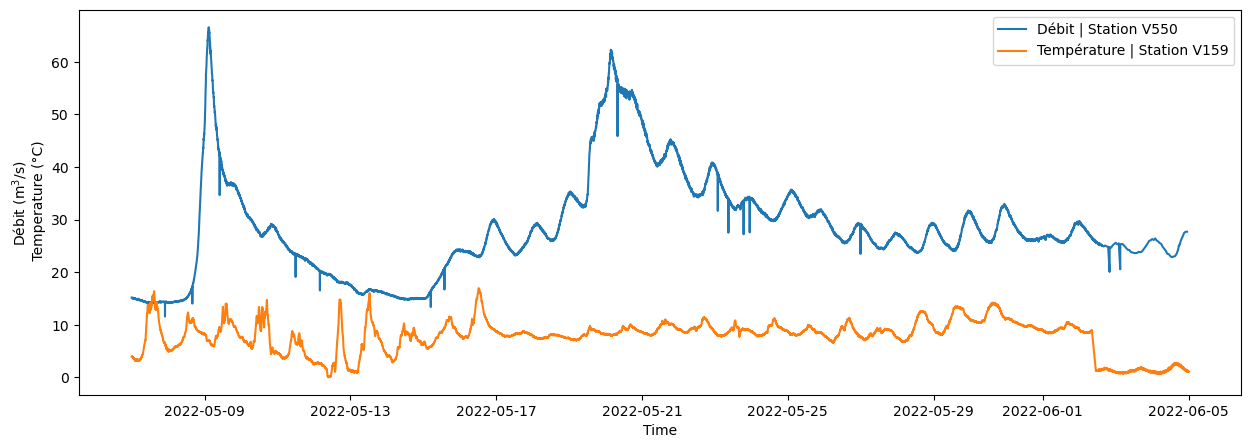

In [5]:
fig = plt.figure(figsize=(15, 5))
plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()
plt.show()

## Determining the frequency of the signal
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

In [6]:
#sample_rate = 180
temp = np.array(temp)
amp_temp =np.abs(np.fft.rfft(temp, n=temp.size))
freq_temp = np.fft.rfftfreq(temp.size, d=1/456)
amp_temp[0] = 0
idx = amp_temp.argmax()
print(freq_temp[idx])

0.138349514563


In [7]:
#sample_rate = 180
gauging_velos = np.array(gauging_velos)
amp_gauging_velos =np.abs(np.fft.rfft(gauging_velos, n=gauging_velos.size))
freq_gauging_velos = np.fft.rfftfreq(gauging_velos.size, d=1/288)
amp_gauging_velos[0] = 0
idx = amp_gauging_velos.argmax()
print(freq_gauging_velos[idx])

0.0371517027864


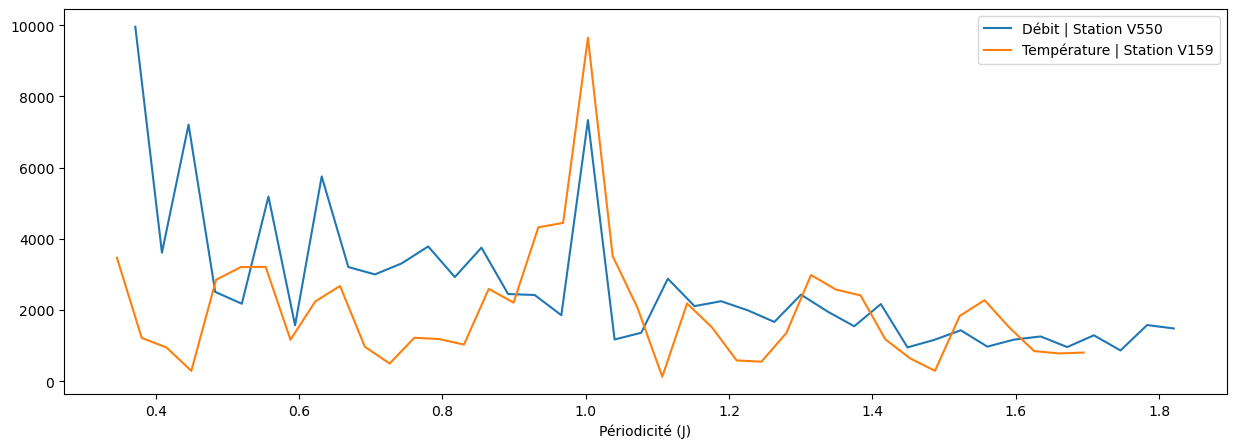

In [8]:
fig = plt.figure(figsize=(15, 5))
plt.plot(freq_gauging_velos[10:50], amp_gauging_velos[10:50], label="Débit | Station V550")
plt.plot(freq_temp[10:50], amp_temp[10:50] , label="Température | Station V159")
plt.xlabel('Périodicité (J)')
plt.legend()
plt.show()


In [9]:
n=1
max_temp = []
max_velos = []
for i in range(len(temp_time)):
    #print(i)
    if temp_time[0] == temp_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(temp[i-456:i]) + (i-456)
        max_temp.append(temp_time[idx])
        #print(i-456)
        n+= 1
        
n=1        
for i in range(len(gauging_time)):
    #print(i)
    if gauging_time[0] == gauging_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(gauging_velos[i-289:i]) + (i-289)
        max_velos.append(gauging_time[idx])
        n+= 1
    
delta_time = np.subtract(max_velos, max_temp)

for i in range(len(delta_time)) :
    delta_time[i] = delta_time[i]/datetime.timedelta(hours=1)
    

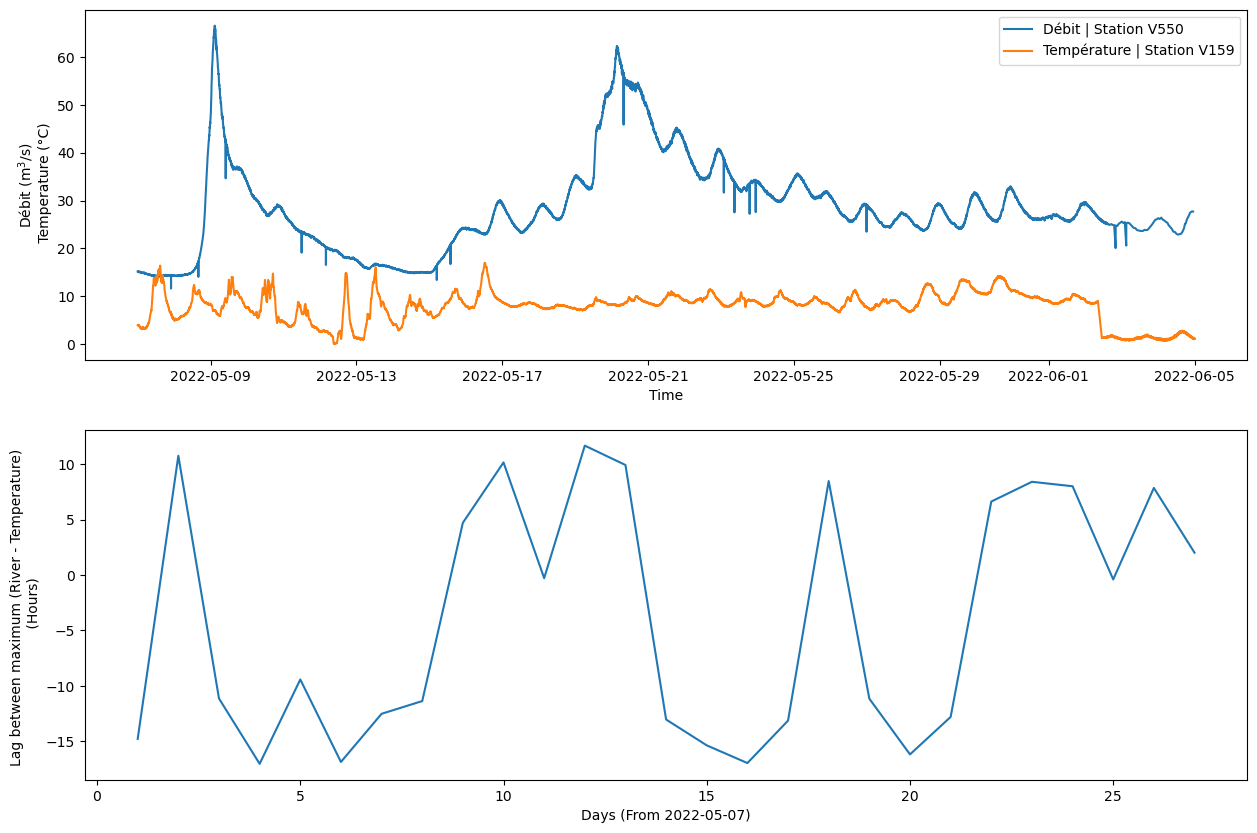

In [10]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

day = list(range(1,28))
#plt.plot(day,max_temp.date())
#plt.plot(day,max_velos.time())
plt.plot(day, delta_time[:27])
plt.xlabel('Days (From 2022-05-07)')
plt.ylabel('Lag between maximum (River - Temperature) \n (Hours)')
plt.show()

## Confronting wave with water

In [11]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
azimuth = ['N','E','Z']
Traces = []
for coump in azimuth :
    Traces.append(obspy.read(root+'453020739.16.2022.05.21.00.00.00.000.'+str(coump)+'.miniseed'))

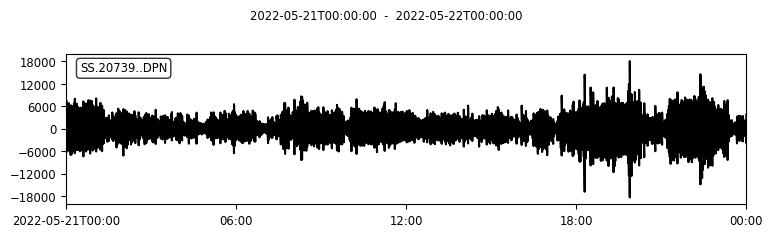

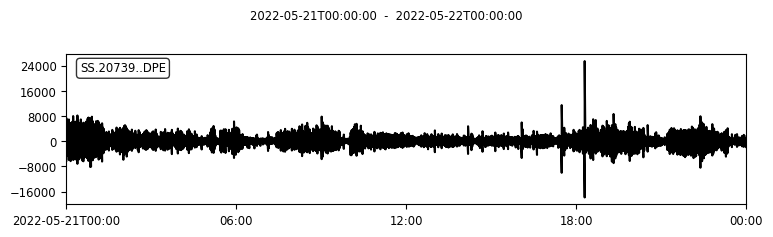

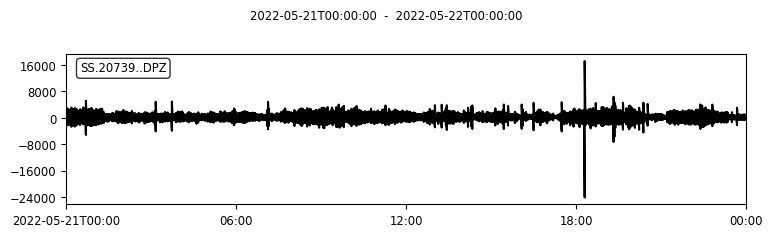

In [12]:
for trace in Traces :
    trace.plot()

In [53]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"

def amp_noise_mean_median(stt,window_size) :


    startday = 8
    startnumber = 3
    days = 26 - startnumber

    median = []
    mean = []

    for day in range(days) :
        start = time.process_time() 
        if startday+day < 10 :
            trace = obspy.read(root+str(stt)+str(startnumber+day)+'.2022.05.0'+str(startday+day)+'.00.00.00.000.Z.miniseed')
        elif startday+day >= 10 :
            trace = obspy.read(root+str(stt)+str(startnumber+day)+'.2022.05.'+str(startday+day)+'.00.00.00.000.Z.miniseed')
        if day == 0 :
            starttime = trace[0].stats.starttime
            noise_time = [starttime]

        window = 24*60/window_size

        trace = np.array(trace[0])

        trace = np.abs(trace)


        npts_p_min = int(len(trace)/(24*60))


        for i in range(int(window)) :
            t0 = i*npts_p_min
            t1 = npts_p_min + i*npts_p_min
            array = trace[t0:t1]
            #mode.append(scipy.stats.mode(array))
            mean.append(np.mean(array))
            median.append(np.median(array))
            if i > 0 and day == 0 :
                noise_time.append(noise_time[i-1]+datetime.timedelta(minutes=window_size))
            elif day > 0 :
                base = int(day*window)
                noise_time.append(noise_time[base+i-1]+datetime.timedelta(minutes=window_size))
        end = time.process_time() 
        print('Days '+str(day+startnumber)+' accomplished in '+str(end-start)+' seconds')
    return noise_time, mean, median

In [126]:
print(len(median))
print(len(mean))
print(len(noise_time))

3312
3312
3312


Days 3 accomplished in 15.4375 seconds
Days 4 accomplished in 15.40625 seconds
Days 5 accomplished in 14.203125 seconds
Days 6 accomplished in 19.65625 seconds
Days 7 accomplished in 15.921875 seconds
Days 8 accomplished in 16.375 seconds
Days 9 accomplished in 20.28125 seconds
Days 10 accomplished in 19.421875 seconds
Days 11 accomplished in 19.546875 seconds
Days 12 accomplished in 19.359375 seconds
Days 13 accomplished in 16.125 seconds
Days 14 accomplished in 12.671875 seconds
Days 15 accomplished in 17.78125 seconds
Days 16 accomplished in 17.03125 seconds
Days 17 accomplished in 15.734375 seconds
Days 18 accomplished in 13.515625 seconds
Days 19 accomplished in 19.046875 seconds
Days 20 accomplished in 15.78125 seconds
Days 21 accomplished in 17.53125 seconds
Days 22 accomplished in 16.296875 seconds
Days 23 accomplished in 15.609375 seconds
Days 24 accomplished in 14.015625 seconds
Days 25 accomplished in 17.640625 seconds


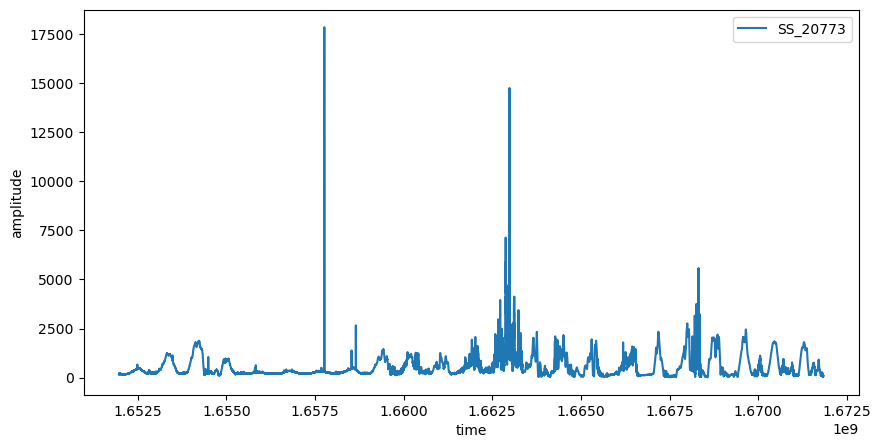

In [54]:
#noise_time773, mean773, median773 = amp_noise_mean_median('453020773.',1)
noise_time739, mean739, median739 = amp_noise_mean_median('453020739.',1)

fig = plt.figure(figsize=(10, 5))
plt.plot(noise_time773,median773, label='SS_20773')
#plt.plot(noise_time739,median739, label='SS_20739')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()
plt.show()

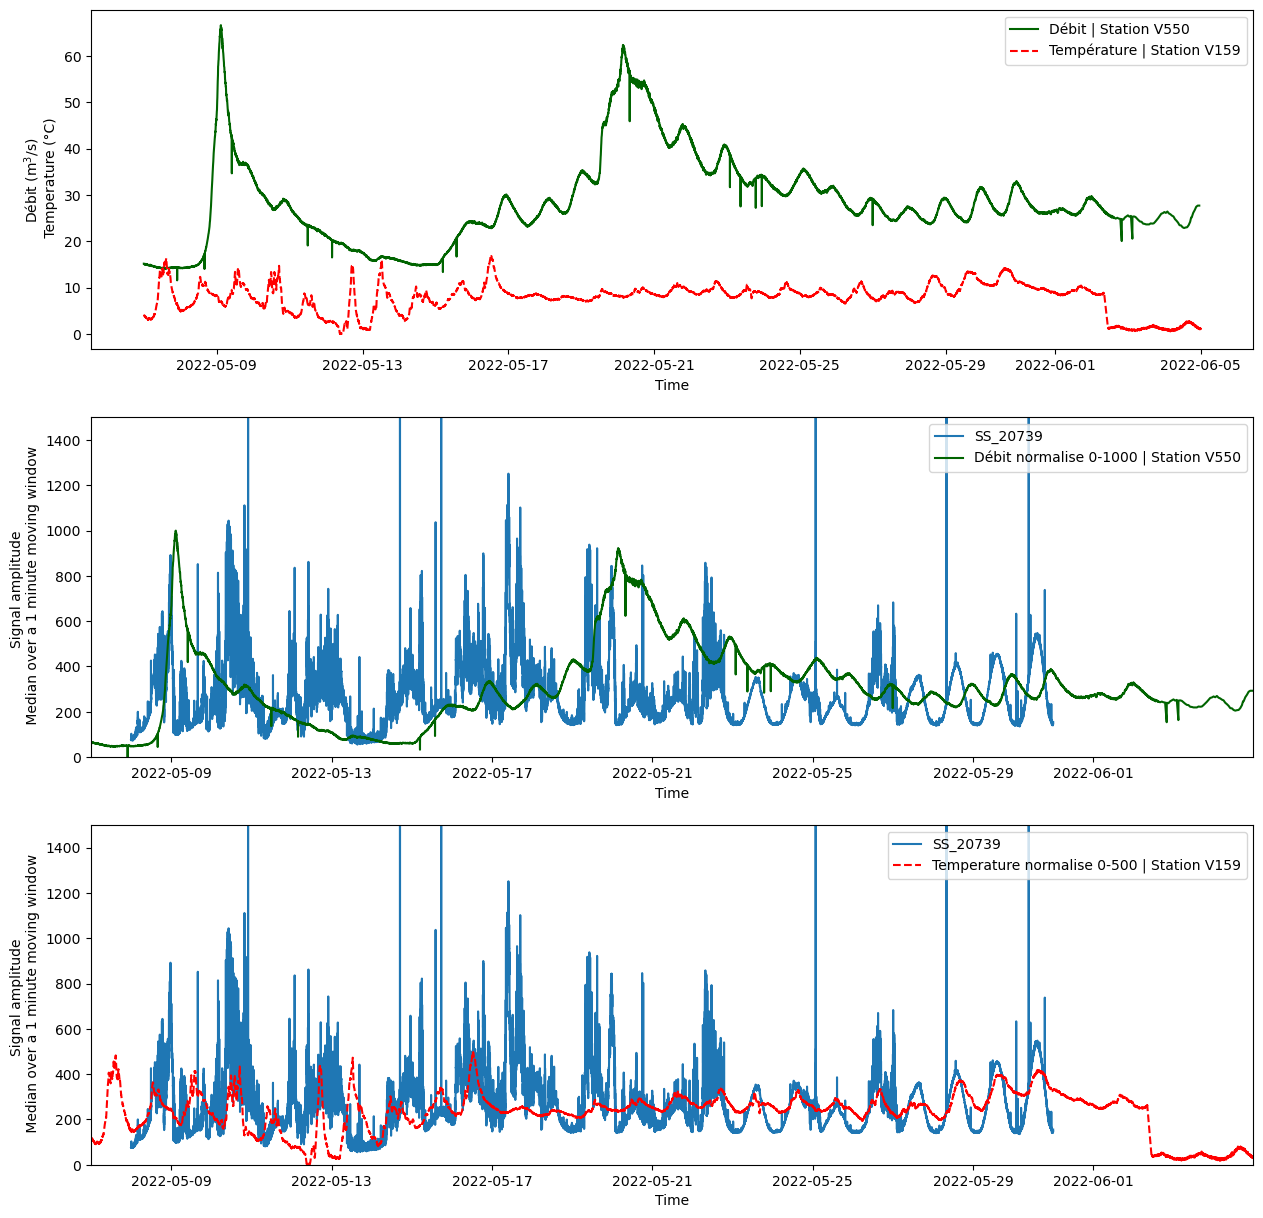

In [92]:
max_velos = np.amax(gauging_velos)
min_velos = np.amin(gauging_velos)
normalise_velos = (gauging_velos - min_velos)/(max_velos-min_velos)*1000

max_temp = np.amax(temp)
min_temp = np.amin(temp)
normalise_temp = (temp - min_temp)/(max_temp-min_temp)*500

fig = plt.subplots(3, 1, figsize=(15, 15))
plt.subplot(3, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='darkgreen')
plt.plot(temp_time, temp, label = 'Température | Station V159', c='red', linestyle='dashed' )
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(3, 1, 2)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(gauging_time,normalise_velos, label = 'Débit normalise 0-1000 | Station V550', c='darkgreen')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.subplot(3, 1, 3)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(temp_time,normalise_temp, label = 'Temperature normalise 0-500 | Station V159', c='red',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.show()



In [17]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
p = obspy.read(root+'453020773.3.2022.05.08.00.00.00.000.Z.miniseed')
p[0].stats

         network: SS
         station: 20773
        location: 
         channel: DPZ
       starttime: 2022-05-08T00:00:00.000000Z
         endtime: 2022-05-09T00:00:00.000000Z
   sampling_rate: 250.0
           delta: 0.004
            npts: 21600001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 6953, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 28479488})

In [ ]:
p.spectrogram(log=True, title='SS_2O781')